# mnist-fashion


## 任务简介

数据集包含 58000 张灰度图片，分10个类别，图片尺寸为 28\*28，要求从 50000 张图片中寻找 10 种服装类别的特征，得到一个图像分类器。并测试 8000 张图片，验证分类器的性能。

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

%matplotlib inline

## 读取数据


In [49]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [50]:
from sklearn.model_selection import train_test_split

X_train = X_train.reshape((-1, 28*28))
X_test = X_test.reshape((-1, 28*28))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train.shape, y_train.shape

((48000, 784), (48000,))

255

## 观察样本

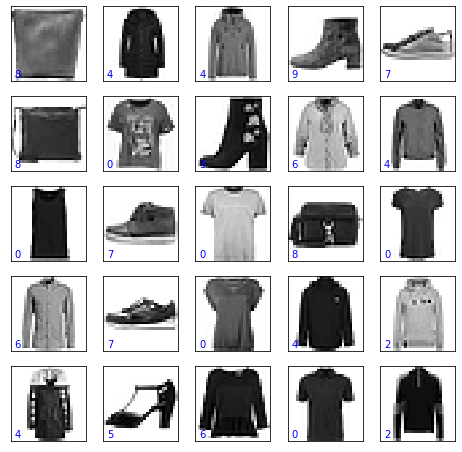

In [6]:
fig, ax = plt.subplots(5, 5, figsize=(8,8))
samples = X_train[0:25]
labels = y_train[0:25]

for axi, sample, label in zip(ax.flat, samples, labels):
    axi.set(xticks=[], yticks=[])
    axi.imshow(sample.reshape((28, 28)), interpolation='nearest', cmap=plt.cm.binary)
    axi.text(0.05, 0.05, str(label),transform=axi.transAxes, color='blue')

## 线性模型

### 数据预处理

首先需要对数据做归一化处理，另外由于数据维度很高（784）可以先对其进行降维。


为了在降维的过程中不至于大量损失原始信息，这里要求选取的主成分要能够保留原始数据 95% 的方差。`sklearn.decomposition.PCA` 这个类的 `n_components` 参数能够接受整数和浮点数作为参数。当为整数是，指明需要选取多少主成分。但为浮点数（0.0~1.0）时，指明需要保存原始数据多少信息。这里传入参数 `n_components=0.95` 即可。

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler


pipeline = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('scaler', StandardScaler())
    
])

X_train_processed = pipeline.fit_transform(X_train)
X_val_processed = pipeline.transform(X_val)

X_train_processed.shape

(48000, 187)

### 构建分类器

In [56]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=200, tol=1e-3, n_jobs=4)

sgd_clf.fit(X_train_processed, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=200, n_iter_no_change=5, n_jobs=4, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### 观察结果

In [57]:
X_val_processed = pipeline.transform(X_val)

y_val_predict = sgd_clf.predict(X_val_processed)

In [58]:
from sklearn.metrics import classification_report

categories_name = ['T恤','裤子','套衫','裙子','外套','凉鞋','汗衫','运动鞋','包','踝靴']

pd.DataFrame(classification_report(y_val, y_val_predict, output_dict=True, target_names=categories_name)).transpose()

,f1-score,precision,recall,support
T恤,0.789835,0.741667,0.844694,1159.000000
裤子,0.962933,0.978477,0.947875,1247.000000
套衫,0.737435,0.717527,0.758478,1209.000000
裙子,0.852146,0.840784,0.863820,1241.000000
外套,0.733635,0.701575,0.768766,1159.000000
凉鞋,0.926037,0.932014,0.920136,1177.000000
汗衫,0.574359,0.671024,0.502037,1227.000000
运动鞋,0.914286,0.922271,0.906438,1165.000000
包,0.941558,0.931727,0.951600,1219.000000
踝靴,0.936869,0.944020,0.929825,1197.000000


In [59]:
from sklearn.metrics import confusion_matrix

con_mat = confusion_matrix(y_val, y_val_predict)

pd.DataFrame(con_mat, index=categories_name, columns=categories_name)

,T恤,裤子,套衫,裙子,外套,凉鞋,汗衫,运动鞋,包,踝靴
T恤,979,4,26,59,8,0,75,0,8,0
裤子,13,1182,14,26,6,0,3,0,2,1
套衫,25,2,917,10,165,0,78,0,12,0
裙子,60,13,17,1072,51,0,24,1,3,0
外套,6,1,111,42,891,0,92,0,15,1
凉鞋,4,1,6,1,0,1083,4,46,16,16
汗衫,221,4,176,48,143,0,616,0,19,0
运动鞋,0,0,0,0,0,55,0,1056,6,48
包,7,1,9,17,6,3,14,2,1160,0
踝靴,5,0,2,0,0,21,12,40,4,1113


## 使用卷积神经网络

In [60]:
def build_model():
    model = keras.Sequential([
        keras.layers.Reshape((28, 28, 1), input_shape=[28 * 28]),
        keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
        keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.Dropout(rate=0.25),
        
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2)),
        keras.layers.Dropout(rate=0.25),
        
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.003),
                  metrics=['acc'])
    return model

model = build_model()

In [30]:
X_train_cnn = X_train / 255.0
X_val_cnn = X_val / 255.0

callbacks = [
    keras.callbacks.EarlyStopping(patience=3, monitor="val_acc")
]
model.fit(X_train_cnn, y_train, epochs=40, batch_size=32, validation_data=(X_val_cnn, y_val), callbacks=callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 12s 243us/sample - loss: 0.6284 - acc: 0.7761 - val_loss: 0.3972 - val_acc: 0.8486
Epoch 2/40
48000/48000 [==============================] - 11s 228us/sample - loss: 0.4220 - acc: 0.8486 - val_loss: 0.3005 - val_acc: 0.8895
Epoch 3/40
48000/48000 [==============================] - 11s 222us/sample - loss: 0.3792 - acc: 0.8620 - val_loss: 0.3474 - val_acc: 0.8702
Epoch 4/40
48000/48000 [==============================] - 11s 225us/sample - loss: 0.3465 - acc: 0.8743 - val_loss: 0.2605 - val_acc: 0.9021
Epoch 5/40
48000/48000 [==============================] - 11s 237us/sample - loss: 0.3055 - acc: 0.8889 - val_loss: 0.2534 - val_acc: 0.9069
Epoch 6/40
48000/48000 [==============================] - 11s 228us/sample - loss: 0.3215 - acc: 0.8843 - val_loss: 0.2484 - val_acc: 0.9062
Epoch 7/40
48000/48000 [==============================] - 11s 224us/sample - loss: 0.2852 - acc: 0.8978 

In [62]:
y_val_predict = model.predict_classes(X_val_cnn)

con_mat = confusion_matrix(y_val, y_val_predict)

pd.DataFrame(con_mat, index=categories_name, columns=categories_name)

,T恤,裤子,套衫,裙子,外套,凉鞋,汗衫,运动鞋,包,踝靴
T恤,1076,0,26,17,1,0,37,0,2,0
裤子,1,1228,1,15,0,0,1,0,1,0
套衫,15,0,1137,11,26,0,20,0,0,0
裙子,33,2,9,1165,21,0,11,0,0,0
外套,2,3,88,40,973,0,53,0,0,0
凉鞋,0,0,0,0,0,1154,0,16,1,6
汗衫,180,0,119,35,55,0,834,0,4,0
运动鞋,0,0,0,0,0,3,0,1145,0,17
包,2,0,7,2,1,0,0,0,1207,0
踝靴,0,0,0,0,0,6,0,47,1,1143


In [63]:
pd.DataFrame(classification_report(y_val, y_val_predict, output_dict=True, target_names=categories_name)).transpose()

,f1-score,precision,recall,support
T恤,0.871961,0.822002,0.928387,1159.000000
裤子,0.990323,0.995945,0.984763,1247.000000
套衫,0.875963,0.819755,0.940447,1209.000000
裙子,0.922407,0.906615,0.938759,1241.000000
外套,0.870304,0.903435,0.839517,1159.000000
凉鞋,0.986325,0.992261,0.980459,1177.000000
汗衫,0.764086,0.872385,0.679707,1227.000000
运动鞋,0.965023,0.947848,0.982833,1165.000000
包,0.991376,0.992599,0.990156,1219.000000
踝靴,0.967414,0.980274,0.954887,1197.000000


## 总结

对比神经网络，这些需要手动选取特征的方法，显得缺少竞争力。尤其是对于图像分类的任务，卷积神经网络能够更加高效地提取到图像中的特征，得到效果更好的模型。另外还能利用以及训练好的模型中的卷积层部分来完成特征提取，这对于训练数据较少的场景很有帮助。

虽然，神经网络在近些年大放异彩，但是深入掌握传统机器学习中的经典方法，对于深刻理解各类机器学习算法很有帮助。